# SSD

## Setup
Import libraries

In [1]:
import cv2
import torch, torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.detection.ssd import SSDClassificationHead
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import time

## Pre-Training

Load SSD model with pretrained VGG16 backbone

In [ ]:
ssd = torchvision.models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.DEFAULT)
ssd

Change the final classification layer to predict the # of categories we are looking for (with same input dims and anchors nums). No need to alter the bounding box regression head

In [3]:
ssd.head.classification_head = SSDClassificationHead([512, 1024, 512, 256, 256, 256], [4, 6, 6, 6, 4, 4], 4)
ssd

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Load 500 images from the dataset. Looks like the most common box category is cyclists, followed by pedestrians

In [ ]:
i = 0
num = 500
images = []
targets = []

labels_list = ['__background__','pedestrian', 'cyclist', 'motorcyclist', 'tricyclist', 'wheelchairuser', 'mopedrider']
cyclist_cnt, ped_cnt, other_cnt = 0, 0, 0

directory = list(os.walk('../dataset/labels'))
for f in directory[0][2]:
    if i >= num:
        break
    i += 1

    with open('../dataset/labels/' + f) as file:
        jsonfile = json.load(file)

        image = cv2.imread('../dataset/images/' +jsonfile['imagename'])
        transform = transforms.Compose([transforms.ToTensor()])
        images.append(transform(image))

        dict = {}
        boxes, labels = [], []
        for bbox in jsonfile['children']:
            if bbox['identity'] == 'cyclist':
                cyclist_cnt += 1
            elif bbox['identity'] == 'pedestrian':
                ped_cnt += 1
            else:
                other_cnt += 1
            label = labels_list.index(bbox['identity'])
            if label >= 3:
                label = 3
            labels.append(label)
            boxes.append([bbox['mincol'], bbox['minrow'], bbox['maxcol'], bbox['maxrow']])
        targets.append({'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)})
print('cyclists: {}, pedestrians: {}, other: {}'.format(cyclist_cnt, ped_cnt, other_cnt))
print(targets)

## Training

Fine tune our pretrained model on 300 images (with batch size of 20) for 10 epochs. Also save model parameters 

In [5]:
optimizer = torch.optim.SGD(ssd.parameters(), lr=0.0001, momentum=0.9)

In [6]:
loss_list = []
best_loss = 1000
file = os.path.join(os.getcwd(), 'ssd.pt')
start = time.time()
for epoch in range(10):
    ssd.train()
    loss_sublist = []
    for i in range(15):
        # print(i)
        cur = i*20
        X = images[cur:cur+20]
        y = targets[cur:cur+20]
        
        j = 0
        while j < len(y):
            if len(y[j]['boxes'].detach().numpy()) == 0:
                X.pop(j)
                y.pop(j)
                j -= 1
            j += 1
        if len(y) == 0:
            continue

        loss = ssd(X, y)
        print(loss)
        losses = sum(l for l in loss.values())
        print(str(loss['bbox_regression'].item()), str(loss['classification'].item()))
        loss_sublist.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    if np.mean(loss_sublist) < best_loss:
        torch.save(ssd.state_dict(), file)
        best_loss = np.mean(loss_sublist)
        print('current model saved')
    
    print('epoch '+str(epoch)+' combined loss: '+str(loss_list[-1]))
end = time.time()
print('time', end-start)

{'bbox_regression': tensor(1.7546, grad_fn=<DivBackward0>), 'classification': tensor(16.3597, grad_fn=<DivBackward0>)}
1.7546128034591675 16.359731674194336
{'bbox_regression': tensor(2.5137, grad_fn=<DivBackward0>), 'classification': tensor(13.9315, grad_fn=<DivBackward0>)}
2.5137417316436768 13.93146800994873
{'bbox_regression': tensor(2.4259, grad_fn=<DivBackward0>), 'classification': tensor(12.0371, grad_fn=<DivBackward0>)}
2.4258642196655273 12.03707218170166
{'bbox_regression': tensor(1.3071, grad_fn=<DivBackward0>), 'classification': tensor(10.6331, grad_fn=<DivBackward0>)}
1.3070921897888184 10.633125305175781
{'bbox_regression': tensor(5.1313, grad_fn=<DivBackward0>), 'classification': tensor(9.6497, grad_fn=<DivBackward0>)}
5.131282806396484 9.649702072143555
{'bbox_regression': tensor(3.3409, grad_fn=<DivBackward0>), 'classification': tensor(8.6232, grad_fn=<DivBackward0>)}
3.3408775329589844 8.623205184936523
{'bbox_regression': tensor(2.8852, grad_fn=<DivBackward0>), 'clas

## Evaluation

Let's visualize how our model performs on the same dataset as Faster R-CNN. Note that all of these images were used during training (since we selected 300 images instead of 100), but we can still see that the results are poor. Here, I've tweaked the code below to save 30 images each to folders images1/, images2/ and images3/

In [5]:
ssd.load_state_dict(torch.load('ssd.pt'))

C:\Users\joshu\AppData\Local\Temp\ipykernel_34752\3802797056.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ssd.load_state_dict(torch.load('ssd.pt'))


<All keys matched successfully>

In [ ]:
new_labels_list = ['__background__','pedestrian', 'cyclist', 'other']

ssd.eval()
for i in range(30):
    X = images[i] # 0, 135, 210
    X_vis = (X.detach().numpy().transpose(1, 2, 0)*255).astype(np.int32).copy()
    z = ssd([X])
    boxes, labels, scores = z[0]['boxes'], z[0]['labels'], z[0]['scores']
    print(scores)
    for box, label, score in zip(boxes.detach().numpy(), labels.detach().numpy(), scores.detach().numpy()):
        if score < 0.5: 
            continue
        #print(box, label)
        color = (255, 255, 255)
        if labels_list[label] == 'cyclist':
            color = (0, 255, 0)
        elif labels_list[label] == 'pedestrian':
            color = (0, 0, 255)
        bbox = [int(pt) for pt in box]
        cv2.rectangle(X_vis, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness=2)
        cv2.putText(X_vis, new_labels_list[label], (bbox[0], bbox[1]), color=color, fontFace=0, fontScale=1)
    cv2.imwrite('images1/'+str(i)+'.png', X_vis)
    # plt.imshow(X_vis)
    plt.show()

Let's also plot the training curve

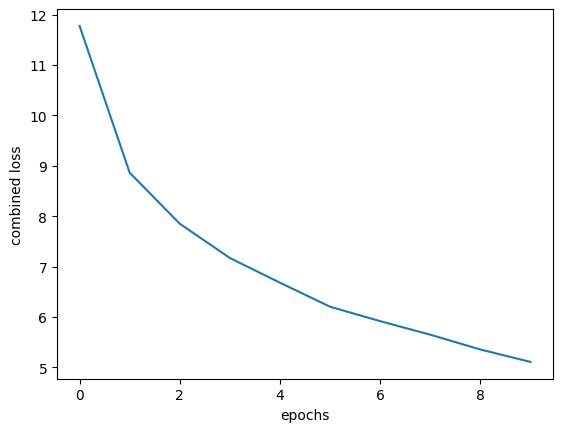

In [13]:
fig, ax = plt.subplots()

ax.plot(list(range(10)), loss_list)
ax.set_ylabel('combined loss')
ax.set_xlabel('epochs')

plt.show()

We can calculate the mAP of our model. The code below prepares input to the mAP script, evaluating on out-of-sample data

In [10]:
ssd.eval()
for i in range(30):
    X = images[i+300]
    y = targets[i+300]
    X_vis = (X.detach().numpy().transpose(1, 2, 0)*255).astype(np.int32).copy()
    #cv2.imwrite('images-optional/'+str(i)+'.png', X_vis)
    
    with open('ground-truth/'+str(i)+'.txt', 'w') as f:
        boxes, labels = y['boxes'], y['labels']
        for box, label in zip(boxes.detach().numpy(), labels):
            f.write(new_labels_list[label]+' '+str(box[0])+' '+str(box[1])+' '+str(box[2])+' '+str(box[3])+'\n')
    
    z = ssd([X])
    boxes, labels, scores = z[0]['boxes'], z[0]['labels'], z[0]['scores']
    with open('detection-results/'+str(i)+'.txt', 'w') as f:
        for box, label, score in zip(boxes.detach().numpy(), labels.detach().numpy(), scores.detach().numpy()):
            if score < 0.5: 
                continue
            bbox = [int(pt) for pt in box]
            f.write(new_labels_list[label]+' '+str(score)+' '+str(bbox[0])+' '+str(bbox[1])+' '+str(bbox[2])+' '+str(bbox[3])+'\n')
        bbox = [int(pt) for pt in box]
        bbox = [int(pt) for pt in box]
    #plt.imshow(X_vis)
    plt.show()